In [1]:

import xarray as xr
import numpy as np
import pandas as pd
from autogluon.tabular import TabularDataset, TabularPredictor
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from helper import timing_wrapper
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.pyplot as plt
import json
plt.rcParams.update(json.load(open('/projekt_agmwend/home_rad/Joshua/MasterArbeit/plot_settings.json')))



/home/jomueller/micromamba/envs/ml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
training_data_pixel = xr.open_dataset('../../data/training_flat.nc')
training_data_segment = pd.read_csv('../../data/training_segment.csv')[2:]

# undersample the data

X = training_data_pixel[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']].to_array().values.T
y = training_data_pixel['y'].values

mask = ~np.isnan(y) & (y != 0) & (y != 3) & ~np.isnan(X).any(axis=1)

X = X[mask]
y = y[mask]

rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X, y)

column_names = ['BT_1', 'BT_25', 'BT_35', 'BT_56', 'BT_36', 'sur_rgh', 'neighbor_mean', 'neighbor_std']

resampled_training_data_pixel = pd.DataFrame(X, columns=column_names)
resampled_training_data_pixel['label'] = y

# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()

# resampled_training_data_pixel[column_names] = scaler.fit_transform(resampled_training_data_pixel[column_names])


train, test = train_test_split(resampled_training_data_pixel, test_size=0.3)




/tmp/ipykernel_2734859/2773913575.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  training_data_segment = pd.read_csv('../../data/training_segment.csv')[2:]


In [5]:
#predictor = TabularPredictor.load("../model/AutogluonModels/ag-20240521_080247")
predictor = TabularPredictor.load("../model/AutogluonModels/ag-20240702_134602")

#feature_importance = predictor.feature_importance(test)

In [5]:
feature_importance.sort_index()

,importance,stddev,p_value,n,p99_high,p99_low
BT_1,0.16408,0.006130,2.332811e-07,5,0.176701,0.151459
BT_25,0.02544,0.002027,4.794100e-06,5,0.029613,0.021267
BT_35,0.01988,0.002975,5.844385e-05,5,0.026006,0.013754
BT_36,0.02152,0.003549,8.558916e-05,5,0.028826,0.014214
BT_56,0.02492,0.005061,1.933587e-04,5,0.035340,0.014500
neighbor_mean,0.30756,0.004877,7.586336e-09,5,0.317602,0.297518
neighbor_std,0.06404,0.004408,2.676048e-06,5,0.073116,0.054964
sur_rgh,0.02900,0.003030,1.409224e-05,5,0.035239,0.022761


(8, 8)
0.125 0.10999999999999999 0.4696969696969697 0.77


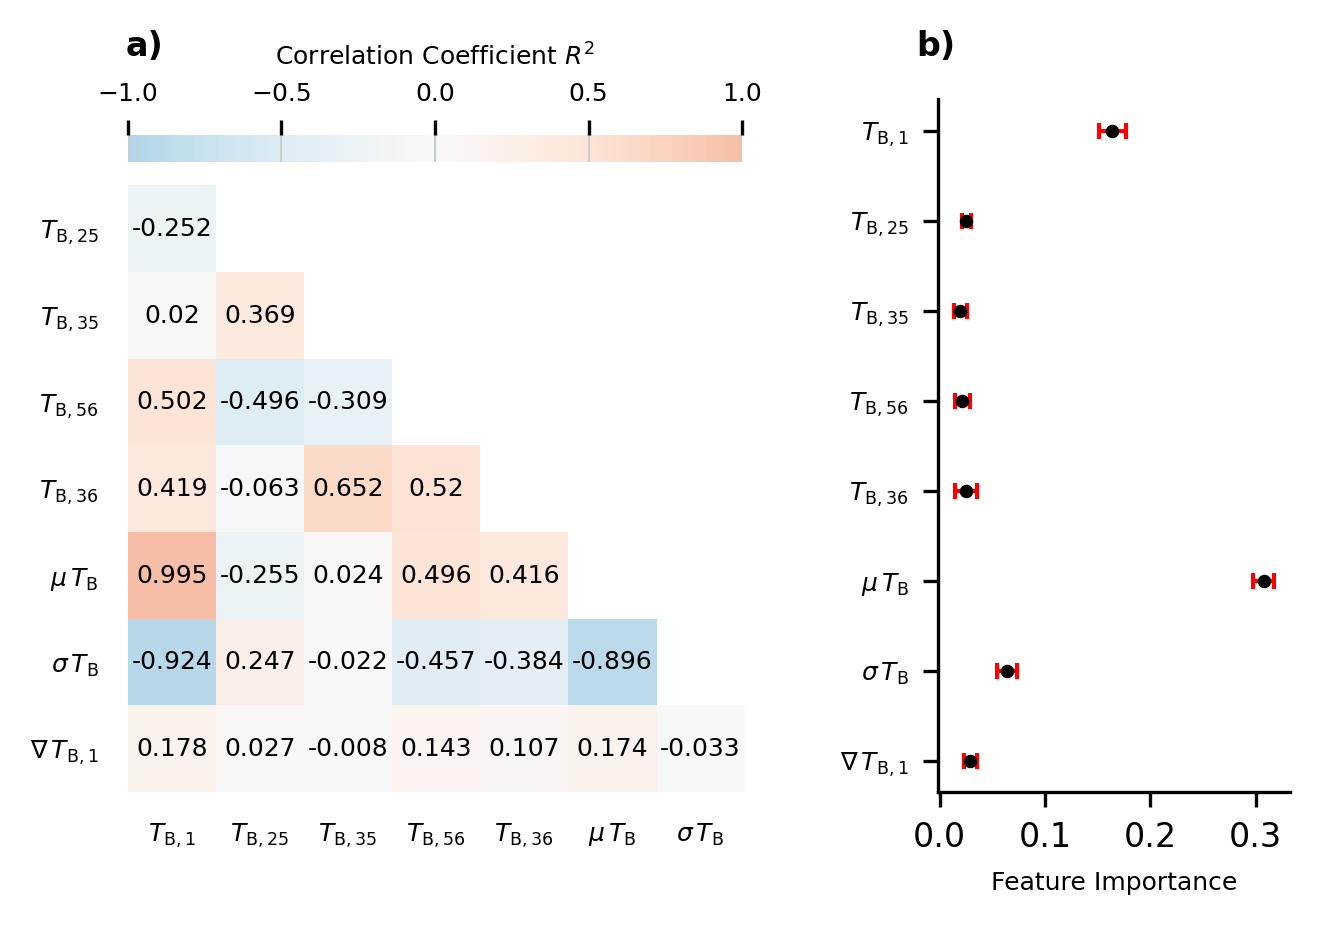

In [6]:
### compute the correlation matrix

corr_matrix = resampled_training_data_pixel[['BT_1', 'BT_25', 'BT_35', 'BT_56', 'BT_36', 'neighbor_mean', 'neighbor_std',  'sur_rgh', ]].corr()

### only keep the lower triangle of the correlation matrix


mask = np.triu(np.ones_like(corr_matrix, dtype=bool))


column_names = [
    '$T_\mathrm{B,1}$', 
    '$T_\mathrm{B,25}$',
    '$T_\mathrm{B,35}$',
    '$T_\mathrm{B,56}$',
    '$T_\mathrm{B,36}$',
    '$\mu\,T_\mathrm{B}$',
    '$\sigma\,T_\mathrm{B}$',
    r'$\nabla\,T_\mathrm{B,1}$',
]

corr_matrix = corr_matrix.mask(mask)

### plot the correlation matrix

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

### make a custom colormap that has a white center an is white until +- 0.3, just shift the red and blue colors
### from RdBu

cmap = plt.cm.RdBu_r

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):

    new_cmap = LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))

    return new_cmap


new_cmap = truncate_colormap(cmap, 0.3, 0.7)
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(5, 3),
                              gridspec_kw={'width_ratios': [2, 1]})

print(corr_matrix.shape)

im = ax.imshow(corr_matrix, cmap=new_cmap, vmin=-1, vmax=1, alpha=.7, aspect='auto')

for i in range(len(column_names)):
    for j in range(len(column_names)):
        if corr_matrix.iloc[i, j] < 1:
            text = ax.text(j, i, round(corr_matrix.iloc[i, j], 3), ha='center', va='center', color='black', fontsize=6)

ax.set_xticks(np.arange(len(column_names)-1))
ax.set_yticks(np.arange(1, len(column_names)))

for a in [ax, ax2]:
    a.spines[['top', 'right', 'left', 'bottom']].set_visible(False)
    a.axes.grid(False)

ax.set_xticklabels(column_names[:-1], fontsize=6)
ax.set_yticklabels(column_names[1:], fontsize=6)

ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

ax2.spines[['left', 'bottom']].set_visible(True)


x = feature_importance['importance'].sort_index().values[::-1]
low_x = feature_importance['p99_low'].sort_index().values[::-1]
high_x = feature_importance['p99_high'].sort_index().values[::-1]

y = np.arange(len(x))

ax2.errorbar(x, y, xerr=[x-low_x, high_x-x], fmt='none', color='red', capsize=2, lw=1)  
ax2.scatter(x, y, color='black', s=5, zorder=10)
ax2.set_yticks(np.arange(len(column_names)))
ax2.set_yticklabels(column_names[::-1], fontsize=6)
ax2.set_xlabel('Feature Importance', fontsize=6)
ax2.set_xticks([0, 0.1, 0.2, 0.3])

# divider = make_axes_locatable(ax)
# cax = divider.append_axes('top', size='5%', pad=-0.15)

l, b, w, h = ax.get_position().bounds
print(l, b, w, h)
#0.125 0.10999999999999999 0.4696969696969697 0.77

cax = fig.add_axes([l, b + h-0.07, w-0.06, 0.03])

cb = fig.colorbar(im, cax=cax, orientation='horizontal', label='Correlation Coefficient $R^2$', ticks=[-1, -0.5, 0, 0.5, 1])
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')
cb.ax.axes.set_frame_on(False)
cb.ax.xaxis.set_label_text('Correlation Coefficient $R^2$', fontsize=6)
### set the colorbar ticklabels size

cb.ax.tick_params(labelsize=6)
#cb.ax.xaxis.set_ticks_position('none')

### add the a) and b) labels

ax.text(0.05, 1.1, 'a)', transform=ax.transAxes, fontsize=8, fontweight='bold', va='top', ha='right')
ax2.text(0.05, 1.1, 'b)', transform=ax2.transAxes, fontsize=8, fontweight='bold', va='top', ha='right')
plt.savefig('../../plots/autogluon_predict.png', dpi=300, bbox_inches='tight')
### label 

In [6]:
train, test = train_test_split(resampled_training_data_pixel, test_size=0.3)

In [8]:
# Uncomment the following line to train a new model

#predictor = TabularPredictor(label='label').fit(train, time_limit=3600, excluded_model_types=['NN_TORCH', 'GBM', 'CAT', 'XGB', 'FASTAI', 'XT'])

In [9]:
predictor.evaluate(test)

{'accuracy': 0.8727899465752466,
 'balanced_accuracy': 0.8532831999662279,
 'mcc': 0.7461511959110996}

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score, roc_curve, precision_score, recall_score

y_pred = predictor.predict(test)
y_true = test['label']

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         1.0       0.93      0.90      0.92    270042
         2.0       0.85      0.71      0.77   1153306
         4.0       0.88      0.95      0.91   2404840

    accuracy                           0.87   3828188
   macro avg       0.89      0.85      0.87   3828188
weighted avg       0.87      0.87      0.87   3828188



In [10]:
cm = confusion_matrix(y_true, y_pred)
#!pip install cmocean

  Using cached cmocean-4.0.3-py3-none-any.whl.metadata (4.2 kB)
Using cached cmocean-4.0.3-py3-none-any.whl (421 kB)


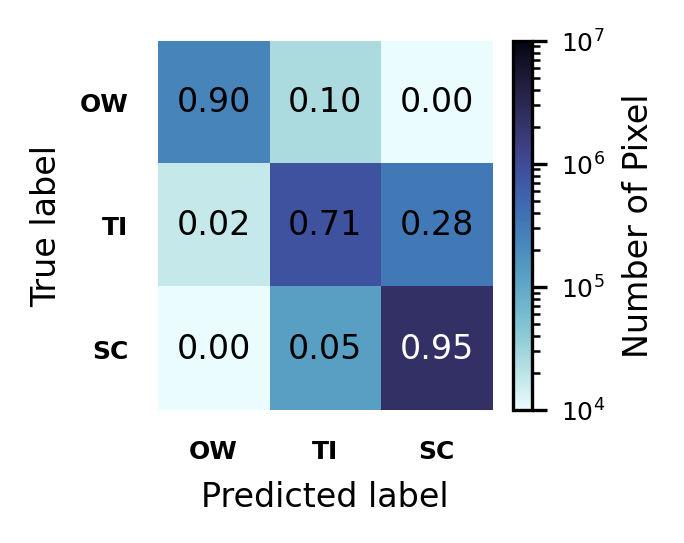

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(1.8, 1.6))
from matplotlib.colors import LogNorm
import cmocean

plt.rcParams.update({
    'font.size' : 8,
    'axes.labelsize' : 8,
    'axes.titlesize' : 8,
    'xtick.labelsize' : 6,
    'ytick.labelsize' : 6,
    'legend.fontsize' : 6
    })


im = ax.imshow(cm, cmap=cmocean.cm.ice_r, norm=LogNorm(1e4, 1e7), aspect='auto')

cbar = fig.colorbar(im, ax=ax, orientation='vertical', label='Number of Pixel')


cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

for i in range(3):
    for j in range(3):
        color = 'white' if cm_norm[i, j] > 0.92 else 'black'
        text = ax.text(j, i, f'{cm_norm[i, j]:.2f}', ha='center', va='center', color=color)

ax.set_xticks(np.arange(3))
ax.set_yticks(np.arange(3))

ticklabels = ['OW', 'TI', 'SC']

ax.set_xticklabels(ticklabels, fontweight='bold')
ax.set_yticklabels(ticklabels, fontweight='bold')

ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

### remove spines and ticks

ax.spines[['top', 'right', 'left', 'bottom']].set_visible(False)
ax.axes.grid(False)
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none') 

plt.savefig('../../plots/autogluon_predict_confusion_matrix_v2.png', dpi=300, bbox_inches='tight')



In [38]:
ds = xr.open_dataset('/projekt_agmwend/home_rad/Joshua/HALO-AC3_VELOX_sea_ice/2022-04-04_v_0.1.nc')
correction_fields = xr.open_dataset('../../data/correction_fields_v1.nc')

In [39]:
#@timing_wrapper
def prepare_load_predict(ds, correction_fields=correction_fields):

    timestep = ds.time
    date = timestep.dt.strftime('%Y-%m-%d')
    # select the correction field for the specific date
    cf = correction_fields.BT_2D.sel(time=date)

    bt = ds.BT_2D.values

    # correct the BT_2D
    bt_corrected = bt - cf

    # replace the BT_2D with the corrected values

    ds['BT_2D'].loc[{'band' : [1, 2, 3, 4]}]  = bt_corrected.isel(band=[1, 2, 3, 4])

    X1 = ds.isel(band=0)['BT_2D']
    X2 = ds.isel(band=1)['BT_2D'] - ds.isel(band=3)['BT_2D']
    X3 = ds.isel(band=2)['BT_2D'] - ds.isel(band=3)['BT_2D']
    X4 = ds.isel(band=3)['BT_2D'] - ds.isel(band=4)['BT_2D']
    X5 = ds.isel(band=2)['BT_2D'] - ds.isel(band=4)['BT_2D']
    X6 = ds['sur_rgh']
    X7 = ds['neighbor_mean']
    X8 = ds['neighbor_std']

    skt = X1 * 1.2 + 4.1
    skt = skt.values

    df_X = pd.DataFrame({
        'BT_1' : X1.values.flatten(),
        'BT_25' : X2.values.flatten(),
        'BT_35' : X3.values.flatten(),
        'BT_56' : X4.values.flatten(),
        'BT_36' : X5.values.flatten(),
        'sur_rgh' : X6.values.flatten(),
        'neighbor_mean' : X7.values.flatten(),
        'neighbor_std' : X8.values.flatten()
    })

    ### scale the data

    df_X = scaler.transform(df_X)

    pred_proba = predictor.predict_proba(df_X, model= 'RandomForestEntr').values.reshape(635, 507, 3)
    #pred_proba = predictor.predict_proba(df_X).values.reshape(635, 507, 3)

    ds_predicted = xr.Dataset(
        {
            'pred_proba': (('x', 'y', 'cl'), pred_proba),
            'label' : (('x', 'y'), np.argmax(pred_proba, axis=-1) * 2 + 1),
            'skin_t' : (('x', 'y'), skt.reshape(635, 507)),
            'BT_1' : X1,
            'BT_25' : X2,
            'BT_35' : X3,
            'BT_56' : X4,
            'BT_36' : X5,
            'sur_rgh' :       X6,
            'neighbor_mean' : X7,
            'neighbor_std' :  X8
        },
        coords={
            'x': ds.x,
            'y': ds.y,
            'cl': ['1', '3', '4']    
        }
    )

    ds_predicted['label'] = xr.where(ds_predicted['label'] == 5, 4, ds_predicted['label'])

    water_ice_mix = (ds_predicted['pred_proba'].sel(cl='1') > .25 ) & (ds_predicted['pred_proba'].sel(cl='3') > .25)

    ### add a second condition for the water_ice_mix: if the skin temperature is below -2.5°C; this is only applied to open water 

    cold_water = (ds_predicted['label'] == 1) & (ds_predicted['skin_t'] < -3.5)
    water_ice_mix = water_ice_mix | cold_water
    ds_predicted['label'] = ds_predicted['label'].where(~water_ice_mix, 2)

    #ice_snow_mix = (ds_predicted['pred_proba'].sel(cl='3') > .45 ) & (ds_predicted['pred_proba'].sel(cl='5') > .45)
    #ds_predicted['label'] = ds_predicted['label'].where(~ice_snow_mix, 4)

    return ds_predicted

In [40]:
ds_predicted = prepare_load_predict(ds.sel(time='2022-04-04T13:39:30'))

import matplotlib.pyplot as plt
import json
plt.rcParams.update(json.load(open('/projekt_agmwend/home_rad/Joshua/MasterArbeit/plot_settings.json')))

fig, ax = plt.subplot_mosaic(
    """
    DABC
    """,
    figsize=(4.5, 1.5),
    gridspec_kw={'width_ratios': [.5, 1, 1, .5], 
                 'hspace': 0.05,
                    'wspace': 0.01,
                 
                 }
)

im = ds_predicted['label'].plot.contourf(levels=[0.5, 1.5, 2.5, 3.5, 4.5], cmap='Dark2', ax=ax['B'], add_colorbar=True, cbar_kwargs={'shrink': 1})
cbar = ax['B'].collections[0].colorbar
cbar.set_ticks([1, 2, 3, 4])
cbar.set_ticklabels(['Open Water', 'Ice Water Mix', 'Thin Ice', 'Snow Covered'], fontsize=6)
cbar.set_label('') 
cbar_ax = cbar.ax


im_norm = plt.Normalize(vmin=ds_predicted.skin_t.min(), vmax=ds_predicted.skin_t.max())


ds_predicted.skin_t.plot.imshow(ax=ax['A'], cmap='viridis',add_colorbar=False)
divider = make_axes_locatable(cbar_ax)
colors = im.cmap([0, 1, 2, 3])

tot_count = 507 * 635

bars =ax['C'].barh([1, 2, 3, 4], [np.sum(ds_predicted['label'] == i) / tot_count for i in [1, 2, 3, 4]], color=colors, )
ax['C'].bar_label(bars, fmt='%.2f', fontsize=6)

ax['A'].set_title('BT')
ax['B'].set_title('pred')
ax['C'].set_title('Class Distribution')


cmap = plt.get_cmap('viridis')
colors_viridis = cmap(np.linspace(0, 1, 256))


im_hist = ax['D'].hist(ds_predicted.skin_t.values.flatten(), bins=100, color='gray', alpha=1, orientation='horizontal')
### reverse the x-axis

ax['D'].invert_xaxis()

### change the color of the bars to the colormap of the skin temperature plot


for i, p in enumerate(im_hist[2]):

    p.set_facecolor(colors_viridis[int((i / 100) * 255)])


for a in ax.values():
    a.grid(False)
    a.set_frame_on(False)

ax['A'].set_xticks([])
ax['A'].set_yticks([])
ax['B'].set_xticks([])
ax['B'].set_yticks([])
ax['A'].set_ylabel('')
ax['B'].set_ylabel('')
ax['A'].set_xlabel('')
ax['B'].set_xlabel('')
ax['A'].set_aspect('equal')
ax['B'].set_aspect('equal')
ax['D'].axes.grid(True)
ax['D'].axes.yaxis.set_tick_params(width=0)
ax['D'].axes.xaxis.set_tick_params(width=0)
ax['C'].axes.grid(True) 
ax['C'].axes.yaxis.set_tick_params(width=0)
ax['C'].set_yticks([])
cbar_ax.set_frame_on(False)
cbar_ax.axes.yaxis.set_tick_params(width=0)
### set the y-distance between colors in the colorbar 


TypeError: data must be TabularDataset or pandas.DataFrame or str file path to data

Computing feature importance via permutation shuffling for 8 features using 5000 rows with 5 shuffle sets...
	27.54s	= Expected runtime (5.51s per shuffle set)
	6.67s	= Actual runtime (Completed 5 of 5 shuffle sets)


<Axes: >

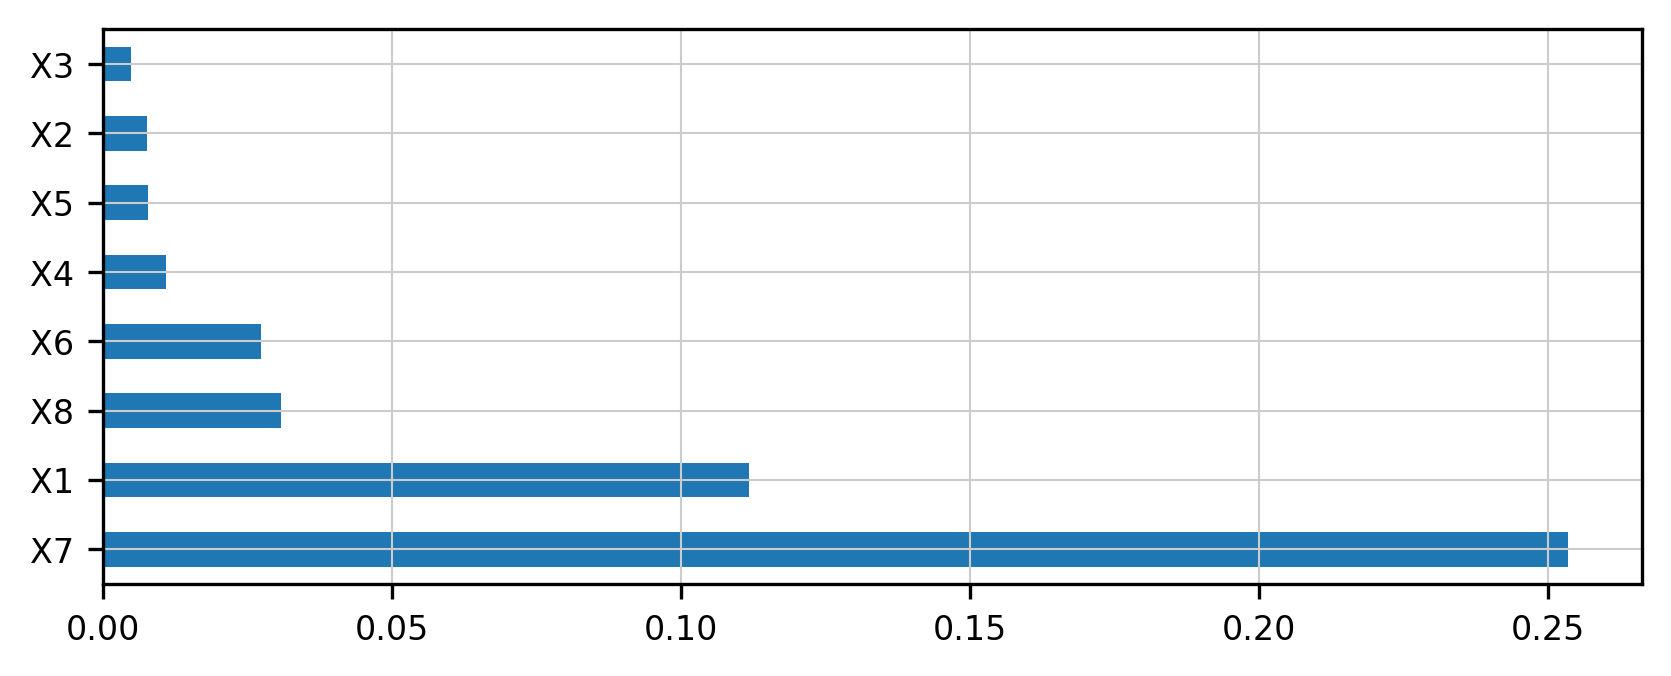

In [ ]:
predictor.feature_importance(test, model= 'RandomForestEntr')['importance'].plot.barh()